# Carbon-Alkalinity-Phosphorus box model
Simplified from Sarmiento and Toggweiler 1984. 
Model parameters are mostly taken from the original 1984 paper. Carbonate chemistry is solved by PyCO2SYS package. Biological export is parameterized as a linear function of phosphate. Sea ice cover can be used to slow down high latitude productivity and air-sea gas exchange. 

The model is set up as initial value problem. It can run in several different modes. 

mode=1: prescribed atmospheric CO2 at 278ppm

mode=2: interactive atmosphere

mode=3: historical and future scenarios (RCP)

It plots the basic output variables, saves the restart file and diagnostic output in npz format.  

In [1]:
### import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PyCO2SYS as pyco2

## Set model parameters
Here many physical paprameters can be changed. 

In [2]:
mod=2     # mod=1: constant atmos pco2 = 278 (pre-industrial)
          # mod=2: interactive atmos pco2, 
          # mod=3: historical and future scenarios (RCP)
# Input integration parameters
dt = 86400*360. # size of a time step (360 days = 1 yr)
N  = 1000 # default number of time steps (N=1000: 1000 years)        
#-----
V=np.array([3e16, 1.6e16, 1.4e18])
Circ=25.4e6
Mix=38.1e6
SST=[21.5,2.5]
SSS=[34.7,34.7]
fice=.5
# biological P uptake rate ([per sec])
bio=1.e-8 
# rain ratio (ST1984 value)
rain=0.15
# C:P ratio
rcp=110.
# Air-sea gas exchange coefficient
G = 3.6/86400. # 3.6m/day
c=Circ/V # volume normalized C
m=Mix/V # volume normalized M

# initialize the carbonate chemistry solver
pyco2_kws = {}
pyco2_kws["par1_type"] = 1  # tell PyCO2SYS: "par1 is alkalinity value"
pyco2_kws["par2_type"] = 2  # tell PyCO2SYS: "par2 is DIC value"
# Define the seawater conditions and add them to the dict
pyco2_kws["salinity"] = SSS  # practical salinity
pyco2_kws["temperature"] = SST  # in-situ temperature (output conditions) in °C
pyco2_kws["pressure"] = 5  # in-situ pressure (output conditions) in dbar, ignoring the atmosphere
# Matm = total moles of gases in the atmosphere
Rearth=6.37e6
Aearth=4.0*np.pi*Rearth**2
Matm = 1013.e+2/9.8/0.0289*Aearth

## Set initial conditions. 
This sections determines the initial values for C, A and P

In [3]:
# set generic initial condition
P=np.array([[0.176], [0.631], [2.26]])
A=np.array([[2283.],[2298.],[2352.]])
C=np.array([[1937.],[2068.],[2247.]])
pco2atm=278.
# read in preindustrial state as initial condition
f=np.load('picontrol.npz')
P=f['P']
A=f['A']
C=f['C']
pco2atm=f['pco2atm']

## Read in atmospheric CO2 if needed
Mode 3 only. 

This automatically adjust the length of the runs

In [4]:
if (mod==3): 
    # read in atmospheric CO2 data, choose one input file
    #df=pd.read_csv('RCP45_MIDYEAR_CONCENTRATIONS.csv',skiprows=37)
    df=pd.read_csv('RCP85_MIDYEAR_CONCENTRATIONS.csv',skiprows=37)
    co2obs=df['CO2']
    yearobs=df['Year']
    pco2atm=co2obs[0]
    N=Nyearobs

## Prepare data arrays for model run

In [5]:
# set transport matrix
T=np.array([[-c[0], 0, c[0]],
            [c[1], -c[1]-m[1], m[1]],
            [0, c[2]+m[2], -c[2]-m[2]]])
# set up bio matrix
B=np.array([[-bio, 0, 0],
            [0, -bio*(1.-fice), 0],
            [bio*V[0]/V[2], bio*(1.-fice)*V[1]/V[2], 0]])
# Invert the matrix for Euler backward P
Mp=np.linalg.inv(np.eye(3)-dt*(T+B))
# Invert the matrix for Euler backward A and C (for transport only)
Mac=np.linalg.inv(np.eye(3)-dt*T)
### data storage array for time-dependent model solutions
Pt=np.zeros((3,N))
At=np.zeros((3,N))
Ct=np.zeros((3,N))
time=np.zeros((N,))
Cinv_atm=np.zeros((N,))
Cinv_ocn=np.zeros((N,))
pco2atmt=np.zeros((N,))
Lexp=np.zeros((N,))
Hexp=np.zeros((N,))
Lfco2=np.zeros((N,))
Hfco2=np.zeros((N,))
LpH=np.zeros((N,))
HpH=np.zeros((N,))

## The actual model integration happens here

In [6]:
# time stepping loop
for n in range(0,N):
    # diagnostics-keeping track of variables
    Cinv_atm[n]=pco2atm*Matm*1.0e-6
    Cinv_ocn[n]=V.T@C*1025.e-6
    Pt[:,n]=P.flatten()
    At[:,n]=A.flatten()
    Ct[:,n]=C.flatten()
    pco2atmt[n]=pco2atm
    time[n]=dt*n
    # solve carbonate chemistry
    pyco2_kws["par1"] = A[:-1].T  # alkalinity
    pyco2_kws["par2"] = C[:-1].T  # DIC in μmol/kg-sw
    CCsol = pyco2.sys(**pyco2_kws)
    Kh=CCsol['k_CO2']
    fco2=CCsol['fCO2']
    # set air-sea flux vector
    A2S=np.zeros((3,1))   
    A2S[0]=-G*Kh[0,0]*(fco2[0,0]-pco2atm)/100
    A2S[1]=-G*(1.-fice)*Kh[0,1]*(fco2[0,1]-pco2atm)/400   
    # step forward P
    P = Mp@P
    # step forward A
    A = Mac@A + dt*rcp*rain*2*B@P
    # step forward C
    C = Mac@C + dt*(A2S + rcp*(1+rain)*B@P)
    # update atmospheric co2
    if (mod==1):
        pco2atm=278.
    elif (mod==2):
        pco2atm=pco2atm-dt*(A2S[0]*V[0]+A2S[1]*V[1])/Matm*1.e3 # step forward atmos pCO2
    elif (mod==3):
        pco2atm=co2obs[n]
    # save additional diagnostics
    Lexp[n]=bio*P[0]*V[0]*rcp*(1+rain)*12.e-18*31104000 # convert to PgC/yr
    Hexp[n]=bio*(1.-fice)*P[1]*V[1]*rcp*(1+rain)*12.e-18*31104000
    Lfco2[n]=A2S[0]*V[0]*12.e-18*31104000
    Hfco2[n]=A2S[1]*V[1]*12.e-18*31104000
    LpH[n]=CCsol["pH"][0,0]
    HpH[n]=CCsol["pH"][0,1]

## Save restart file and diagnostics

In [7]:
np.savez('restart.npz',P=P,C=C,A=A,pco2atm=pco2atm)
np.savez('diagnostics.npz',Lexp=Lexp,Hexp=Hexp,Lfco2=Lfco2,
         Hfco2=Hfco2,Pt=Pt,Ct=Ct,At=At,pco2atmt=pco2atmt,
         Cinv_atm=Cinv_atm,Cinv_ocn=Cinv_ocn,LpH=LpH,HpH=HpH)

## Plot the results

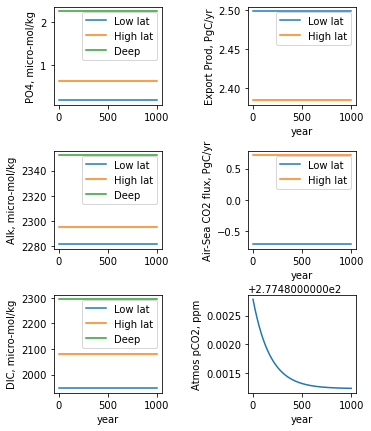

In [8]:
fig=plt.figure(figsize=(6,8))
##
ax11 = fig.add_axes([0.1, 0.75,0.25,0.17])
plt.plot(time/31104000,Pt.T)
plt.legend(['Low lat','High lat','Deep'])
plt.ylabel('PO4, micro-mol/kg')
##
ax21 = fig.add_axes([0.1, 0.5,0.25,0.17])
plt.plot(time/31104000,At.T)
plt.legend(['Low lat','High lat','Deep'])
plt.ylabel('Alk, micro-mol/kg')
##
ax31 = fig.add_axes([0.1, 0.25,0.25,0.17])
plt.plot(time/31104000,Ct.T)
plt.legend(['Low lat','High lat','Deep'])
plt.xlabel('year')
plt.ylabel('DIC, micro-mol/kg')
##
ax12 = fig.add_axes([0.55, 0.75,0.25,0.17])
plt.plot(time/31104000,Lexp,label='Low lat')
plt.plot(time/31104000,Hexp,label='High lat')
plt.legend()
plt.xlabel('year')
plt.ylabel('Export Prod, PgC/yr')
##
ax22 = fig.add_axes([0.55, 0.5,0.25,0.17])
plt.plot(time/31104000,Lfco2,label='Low lat')
plt.plot(time/31104000,Hfco2,label='High lat')
plt.legend()
plt.xlabel('year')
plt.ylabel('Air-Sea CO2 flux, PgC/yr')
##
ax23 = fig.add_axes([0.55, 0.25,0.25,0.17])
plt.plot(time/31104000,pco2atmt)
plt.xlabel('year')
plt.ylabel('Atmos pCO2, ppm')
##
fign='CAP_fig1'
plt.savefig(fign+'.pdf',bbox_inches="tight",dpi=300)
#plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

In [9]:
if (mod==3):
    fig=plt.figure(figsize=(6,8))
    ##
    ax11 = fig.add_axes([0.1, 0.55,0.7,0.35])
    plt.plot(time/31104000+1765,Lfco2,label='Low lat')
    plt.plot(time/31104000+1765,Hfco2,label='High lat')
    plt.plot(time/31104000+1765,Hfco2+Lfco2,label='Global')
    plt.ylabel('ocean carbon uptake, PgC/yr')
    plt.legend()
    ##
    ax21 = fig.add_axes([0.1, 0.1,0.7,0.35])
    plt.plot(time/31104000+1765,LpH,label='Low lat')
    plt.plot(time/31104000+1765,HpH,label='High lat')
    plt.ylabel('pH')
    plt.xlabel('time')
    plt.legend()
    ##
    fign='CAP_fig2'
    plt.savefig(fign+'.pdf',bbox_inches="tight",dpi=300)
    #plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
    plt.show()

In [ ]:
# update the restart file if desired
#! cp restart.npz picontrol.npz
#! cp diagnostics.npz spinup.npz